<div style="text-align:center"> 
    <p style="font-size: 50px; margin-bottom: 0">Death of a Cluster</p>
    <p style="font-size: 20px; font-style: italic">ASTR 511 HW4 - Tom Wagg</p>
    <p>(This title was <a href="https://iopscience.iop.org/article/10.1088/0004-637X/711/2/559">by no means</a> plagiarised...)</p>
</div>

Author: Tom Wagg

Collaborators: Honestly, you'd think I have no friends...

In [1]:
import astropy.coordinates as coord
import astropy.units as u
import numpy as np
import gala.dynamics as gd
import gala.potential as gp
import gala.integrate as gi
from gala.units import galactic
from gala.dynamics import mockstream as ms
from gala.dynamics.nbody import DirectNBody


import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"
plt.style.use("dark_background")

In [2]:
_ = coord.galactocentric_frame_defaults.set('v4.0')

# Part 1: Setup

First we can just set up the coordinates. Most of them we can grab from HW2, but additionally I got the radial velocity from [here](https://arxiv.org/abs/1507.01949).

In [3]:
c = coord.SkyCoord(ra=132.7625 * u.deg, dec=11.49 * u.deg,
                   distance=878 * u.pc,
                   pm_ra_cosdec=-10.97 * u.mas/u.yr * np.cos(11.49 * u.deg),
                   pm_dec=-2.95 * u.mas/u.yr,
                   radial_velocity=33.64 * u.km/u.s)

Now we convert this Astropy `SkyCoord` to a Gala `PhaseSpacePosition`.

In [4]:
c_gc = c.transform_to("galactocentric").cartesian
m67_w0 = gd.PhaseSpacePosition(c_gc)

Finally we can set up a Plummer sphere for the cluster potential.

In [5]:
m67_mass = 1138 * u.Msun
m67_radius = (3.16 * u.arcmin).to(u.rad).value * c.distance * 5
m67_pot = gp.PlummerPotential(m=m67_mass, b=m67_radius, units=galactic)

# Part 2: The Pretend Way

So to start I'm just going to do this using `Gala`'s `MockStreamGenerator` for simplicity. But this has a couple of issues:
- The number of stars that are released from the cluster is a fixed number per timestep (set by `release_every`). This means that the disruption time of the cluster is **essentially meaningless**
- The number of stars released by the cluster is not limited in any way, my little cluster is going to emit ~2x as many stars as it has in the functions below

This stream generator is interesting for looking at the structure of streams in general but doesn't produce _realistic_ results. I'll try something smarter below.

In [6]:
df = ms.FardalStreamDF()

pot = gp.MilkyWayPotential()
gen_m67 = ms.MockStreamGenerator(df, pot, progenitor_potential=m67_pot)
m67_stream, m67_nbody = gen_m67.run(m67_w0, m67_mass, dt=-1 * u.Myr, n_steps=2000)

Let's take a look at what that's made for us

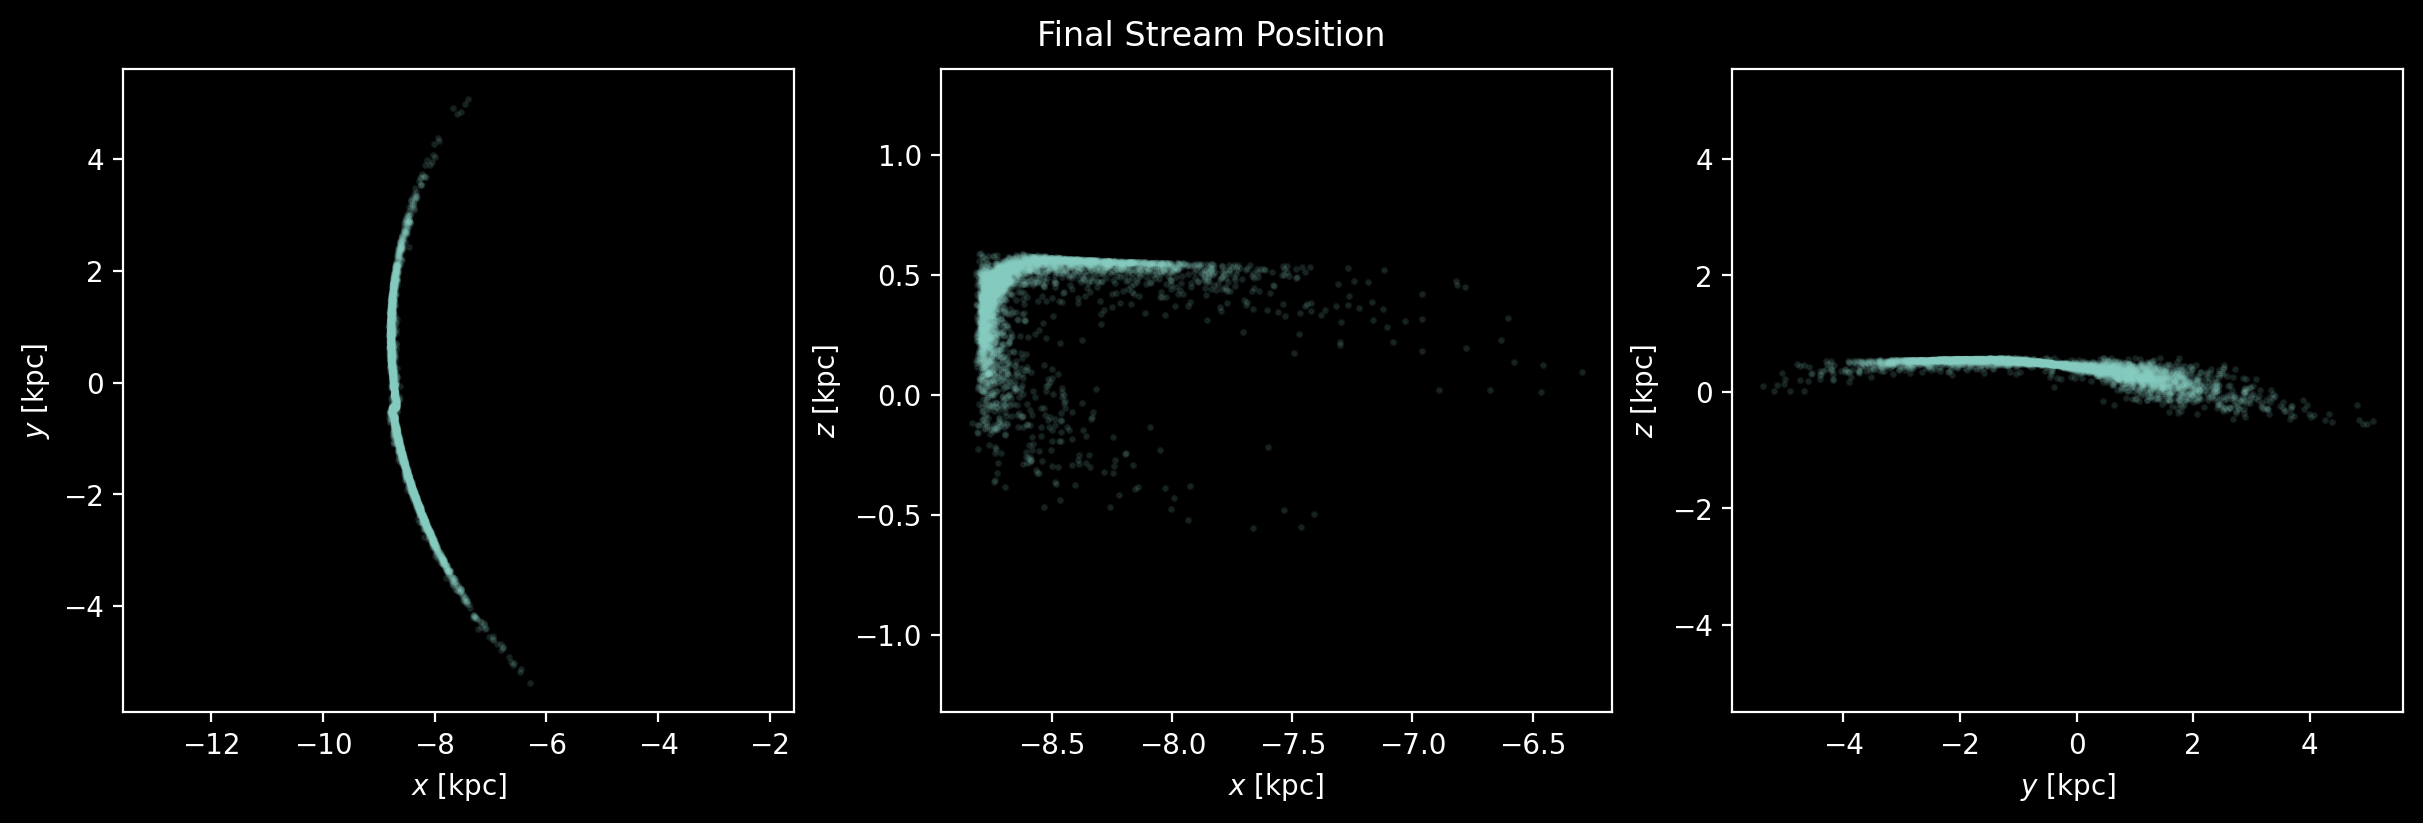

In [7]:
fig = m67_stream.plot(alpha=0.1, s=10)
fig.suptitle("Final Stream Position")
plt.show()

I did also experiment with showing the potential in the background but I don't think this works too well because I have the fix the other coordinate to some value and that doesn't always work (particularly for the middle panel where y should vary a lot)

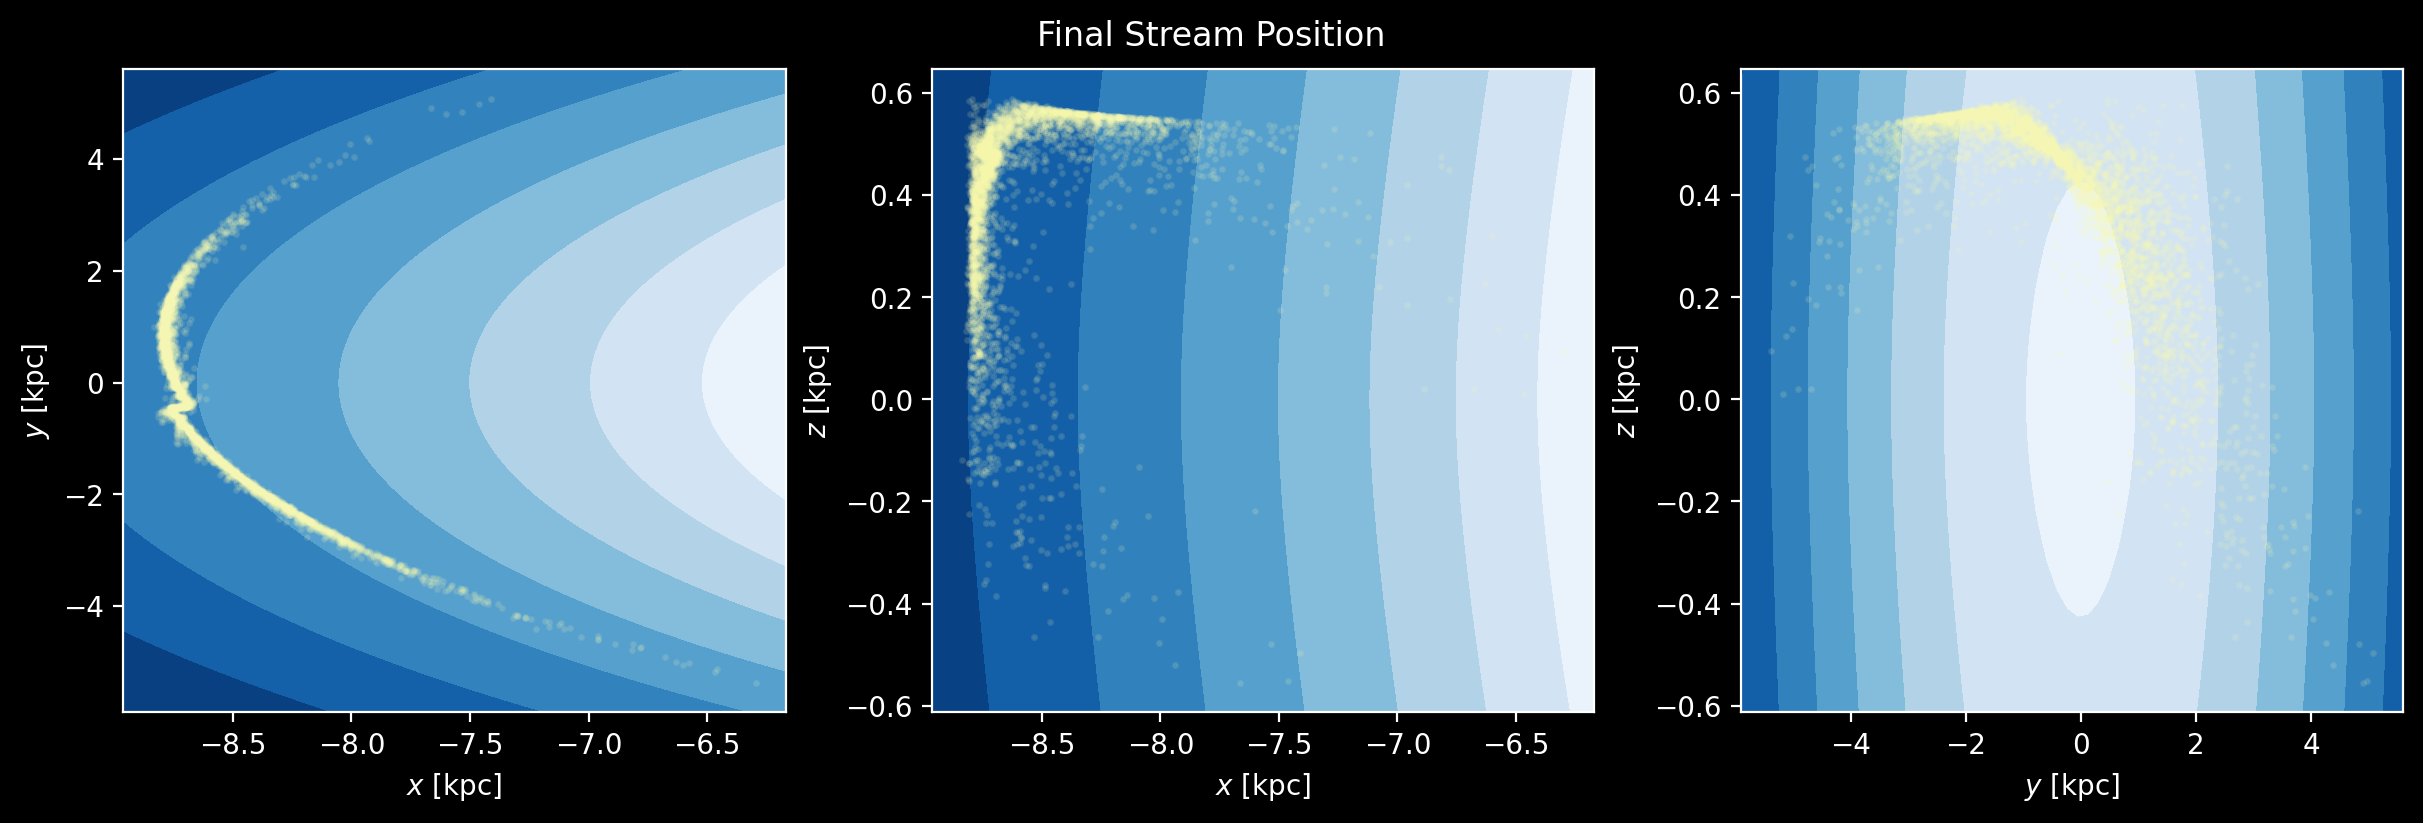

In [8]:
fig = m67_stream.plot(alpha=0.1, s=10, c="C1", autolim=False, auto_aspect=False)
fig.suptitle("Final Stream Position")
axes = fig.get_axes()


pot.plot_contours(grid=(np.linspace(*axes[0].get_xlim(), 64),
                        np.linspace(*axes[0].get_ylim(), 64),
                        0),
                  ax=axes[0], zorder=-1)
pot.plot_contours(grid=(np.linspace(*axes[1].get_xlim(), 64),
                        0,
                        np.linspace(*axes[1].get_ylim(), 64)),
                  ax=axes[1], zorder=-1)
pot.plot_contours(grid=(-8,
                        np.linspace(*axes[2].get_xlim(), 64),
                        np.linspace(*axes[2].get_ylim(), 64)),
                  ax=axes[2], zorder=-1)
plt.show()

We can also look at how the stream would look on the sky

Text(0, 0.5, 'Dec [deg]')

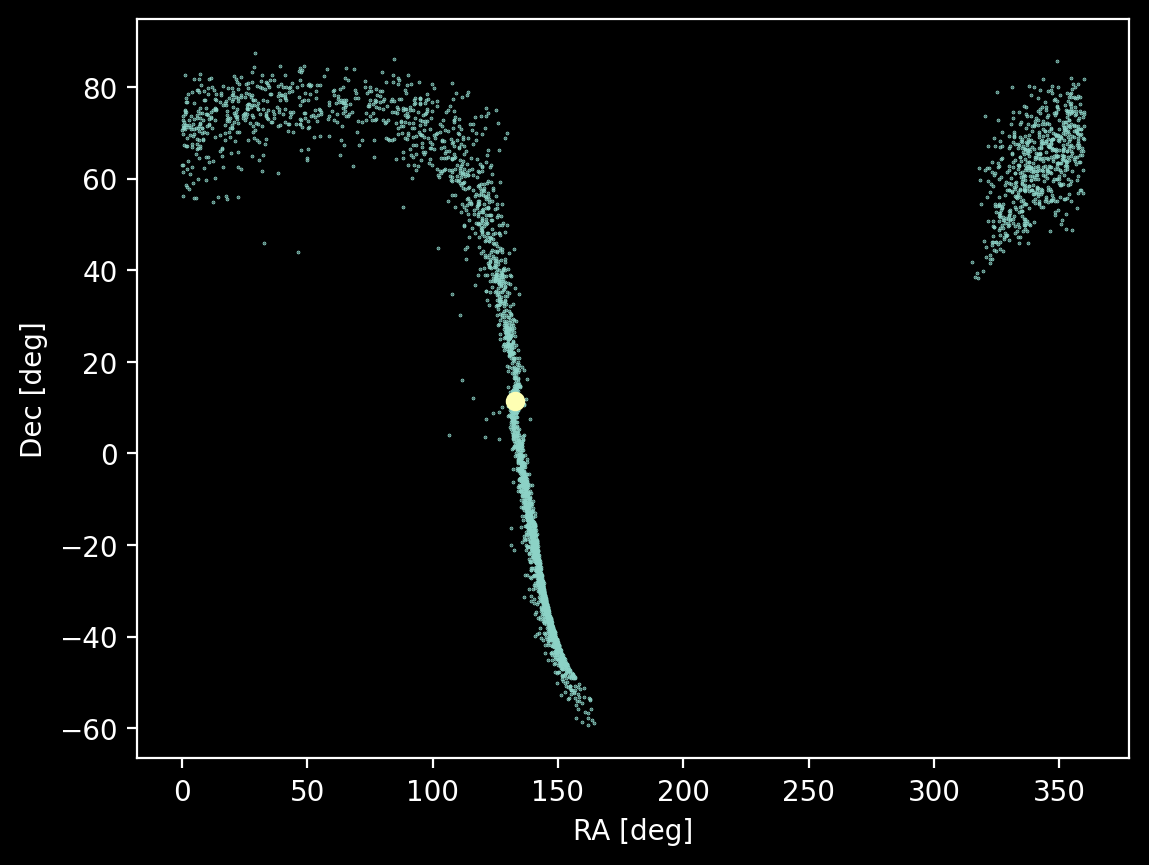

In [9]:
icrs = coord.ICRS()
stream_c = m67_stream.to_coord_frame(icrs)
plt.scatter(stream_c.ra, stream_c.dec, s=0.1);
plt.scatter(c.ra, c.dec)
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")

### Repeat for NFW
We can look at this in the same way with the NFW profile (created using the circular velocity we'd find in a MilkyWayPotential)

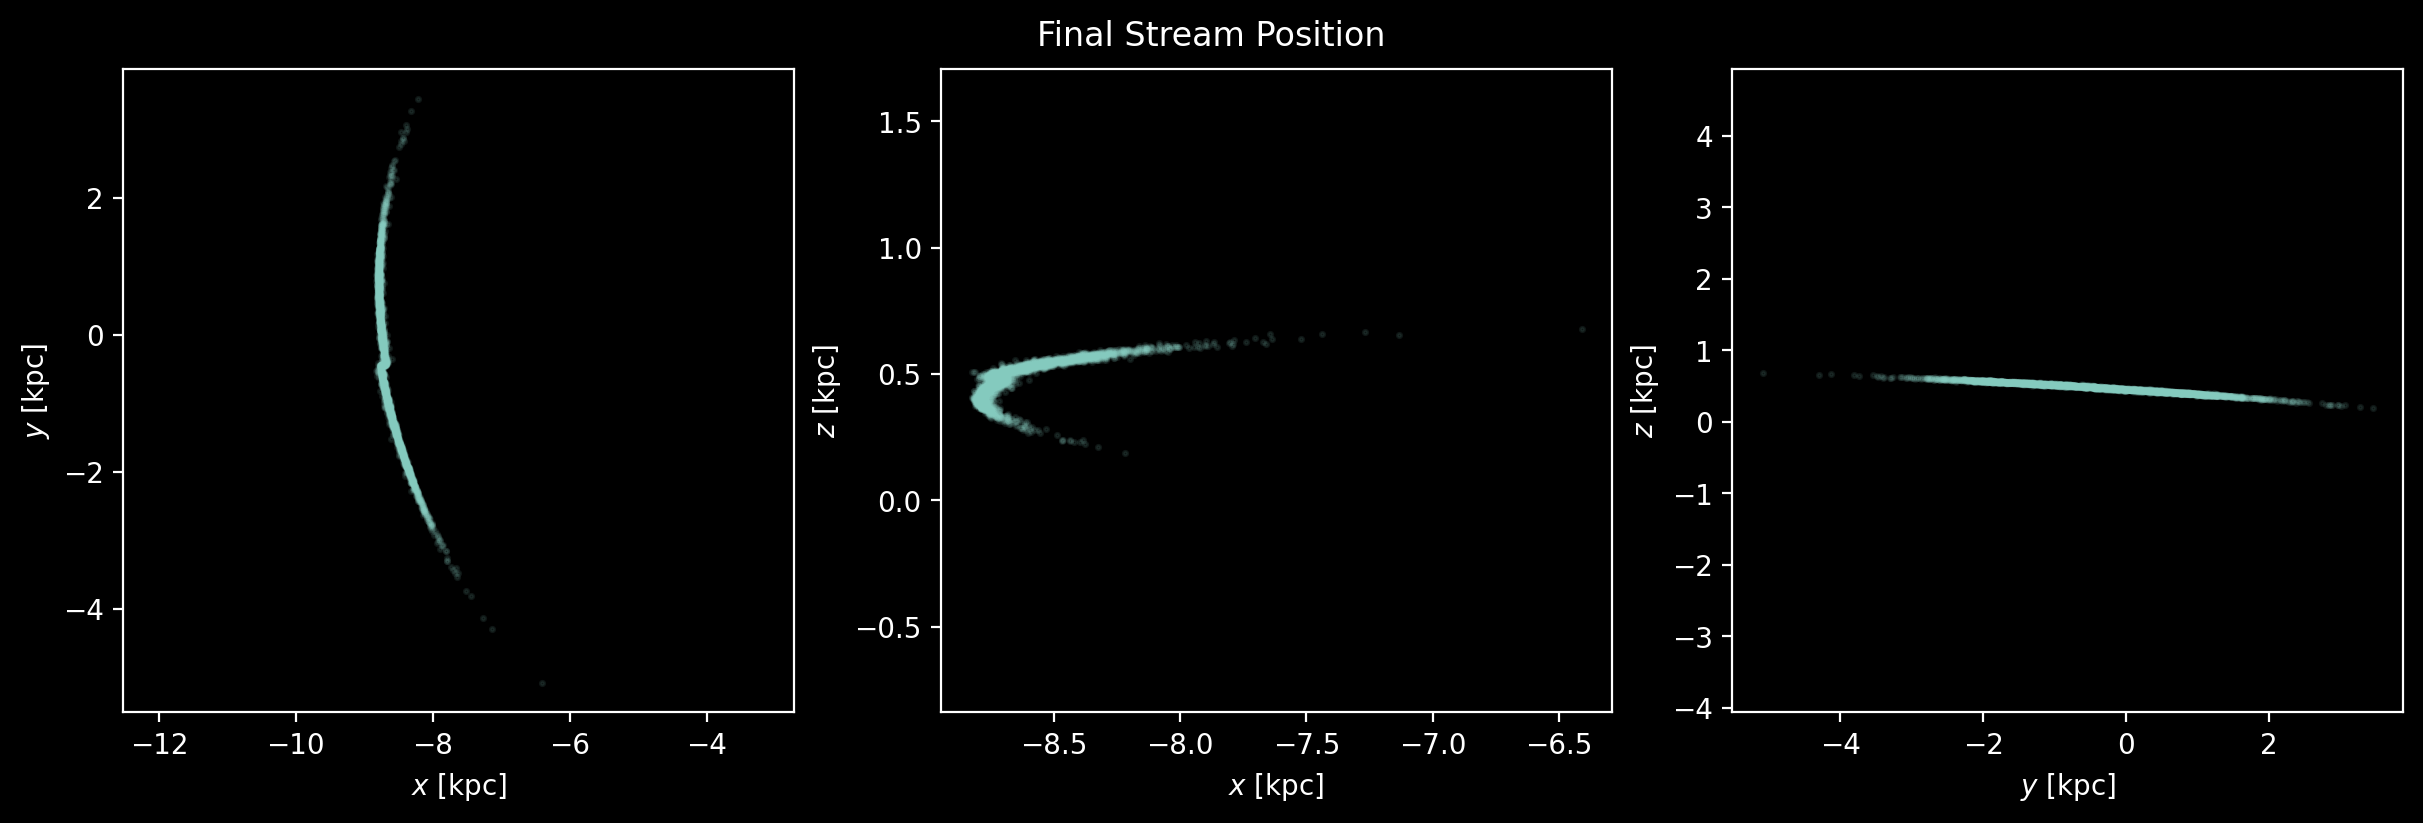

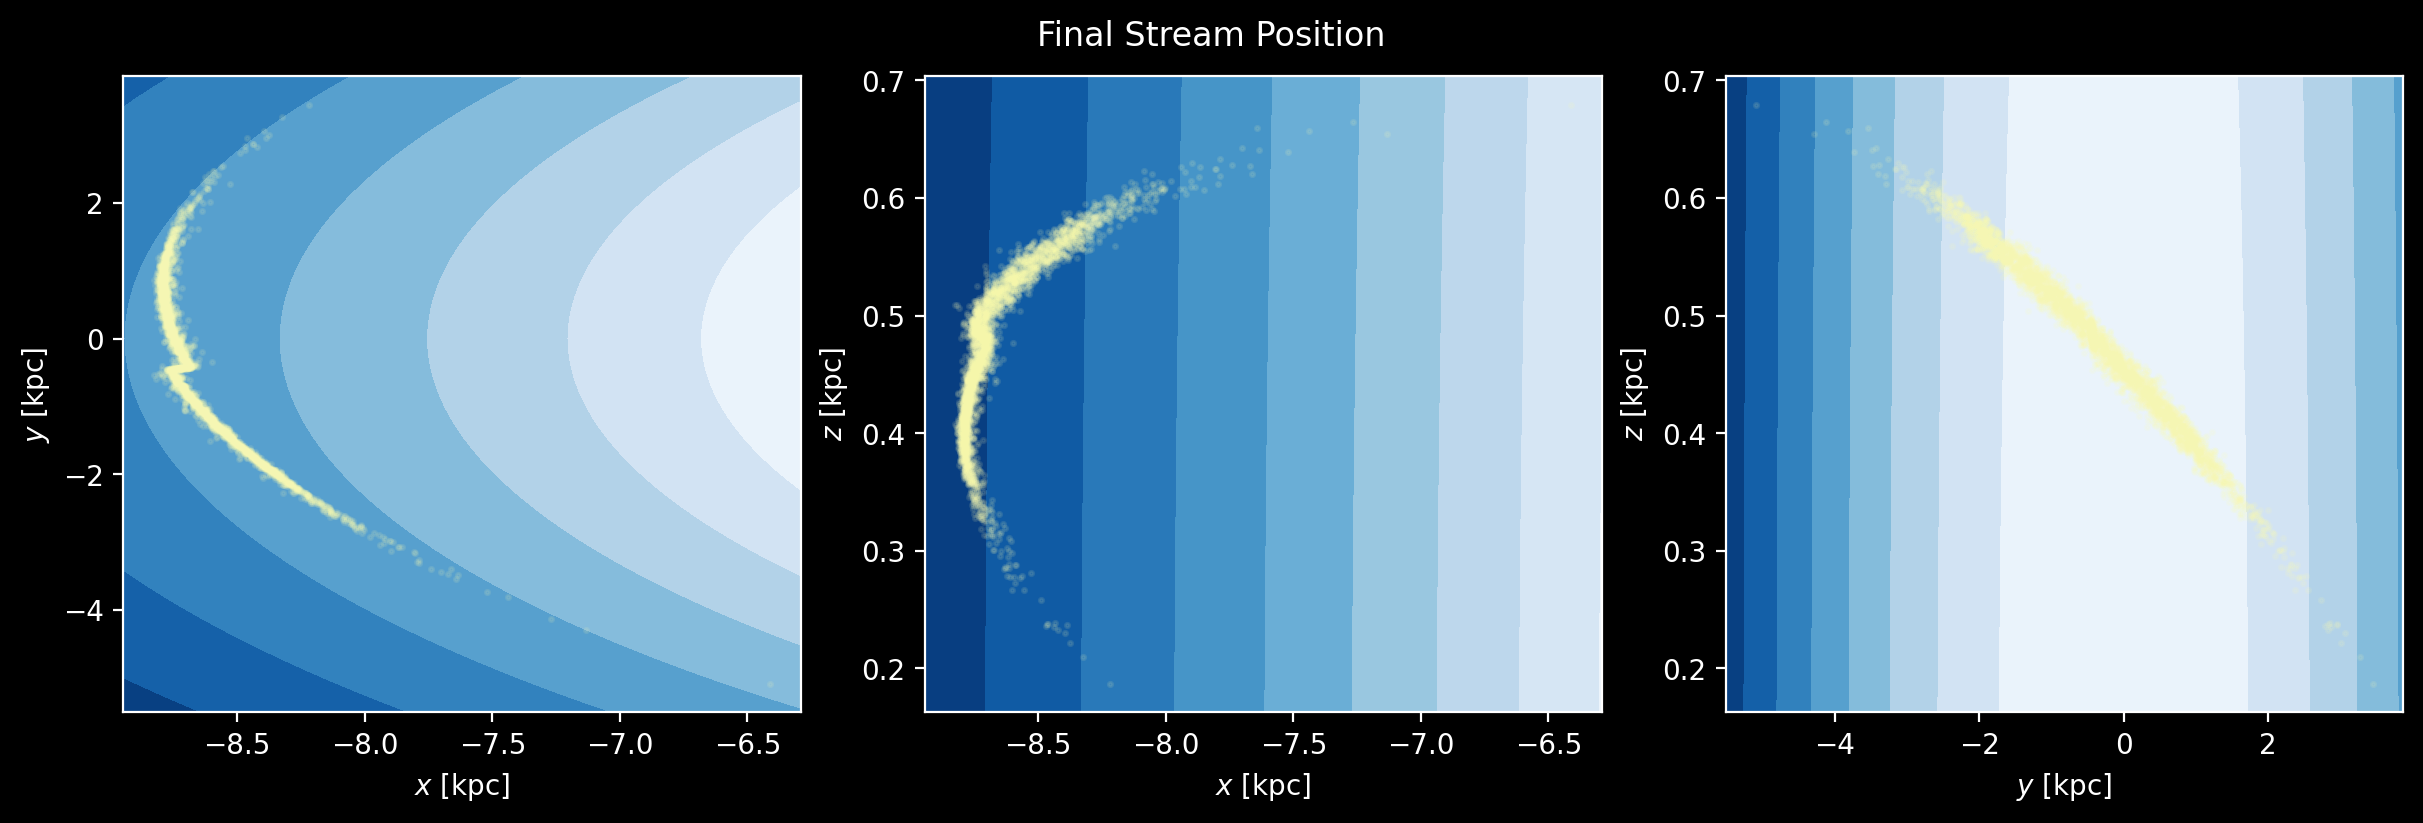

Text(0, 0.5, 'Dec [deg]')

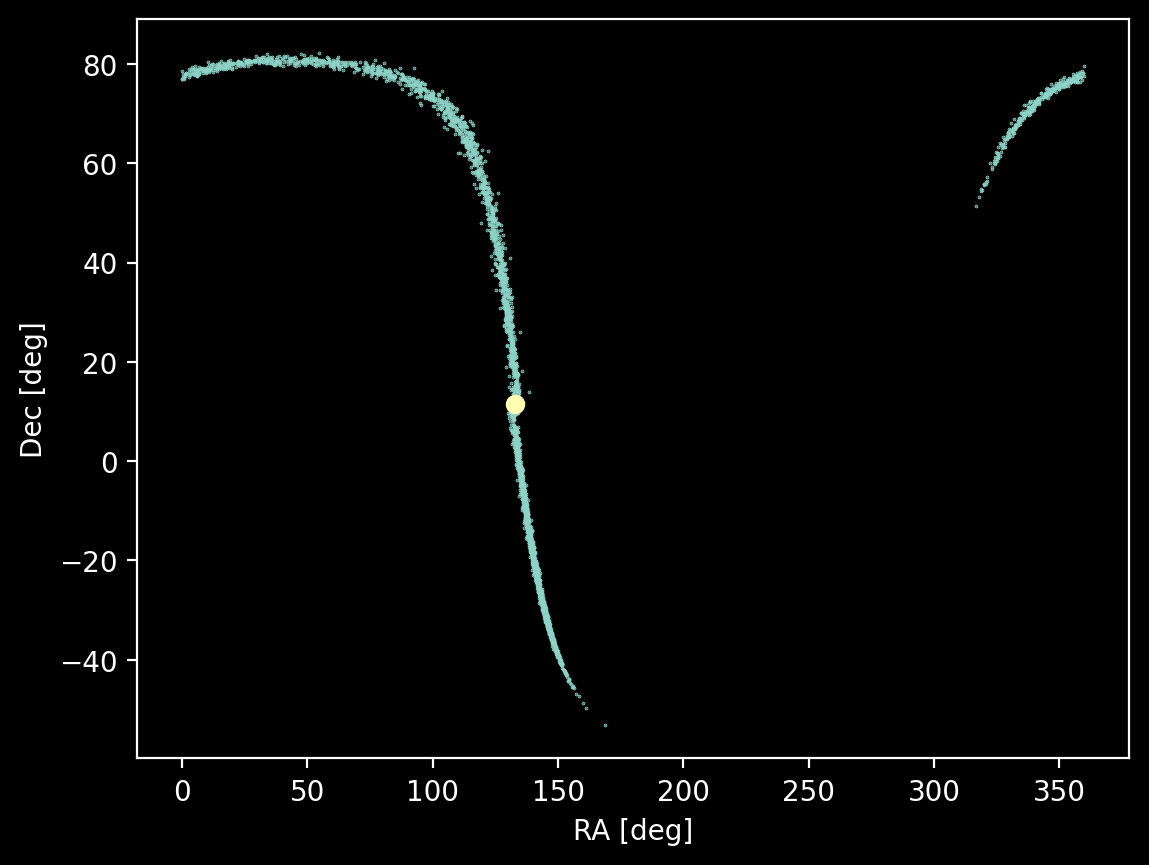

In [10]:
df = ms.FardalStreamDF()

pot = gp.NFWPotential.from_circular_velocity(v_c=gp.MilkyWayPotential().circular_velocity([8.2, 0, 0])[0],
                                             r_s=8.2 * u.kpc, units=galactic)
gen_m67 = ms.MockStreamGenerator(df, pot, progenitor_potential=m67_pot)
m67_stream, m67_nbody = gen_m67.run(m67_w0, m67_mass, dt=-1 * u.Myr, n_steps=2000)

fig = m67_stream.plot(alpha=0.1, s=10)
fig.suptitle("Final Stream Position")
plt.show()

fig = m67_stream.plot(alpha=0.1, s=10, c="C1", autolim=False, auto_aspect=False)
fig.suptitle("Final Stream Position")
axes = fig.get_axes()


pot.plot_contours(grid=(np.linspace(*axes[0].get_xlim(), 64),
                        np.linspace(*axes[0].get_ylim(), 64),
                        0),
                  ax=axes[0], zorder=-1)
pot.plot_contours(grid=(np.linspace(*axes[1].get_xlim(), 64),
                        0,
                        np.linspace(*axes[1].get_ylim(), 64)),
                  ax=axes[1], zorder=-1)
pot.plot_contours(grid=(-8,
                        np.linspace(*axes[2].get_xlim(), 64),
                        np.linspace(*axes[2].get_ylim(), 64)),
                  ax=axes[2], zorder=-1)
plt.show()

icrs = coord.ICRS()
stream_c = m67_stream.to_coord_frame(icrs)
plt.scatter(stream_c.ra, stream_c.dec, s=0.1);
plt.scatter(c.ra, c.dec)
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")

So just qualitatively it looks like the NFW profile gives you a tighter stream than the MilkyWayPotential.

# Part 2: A Better(?) Way

Now let's _try_ to do this a little more realistically. `Gala` has a subpackage for handling simple NBody integration in larger potential fields so let's try creating a particle for each of the stars in the cluster and integrate them through the Milky Way potential and see if we can destroy the cluster. [Update NBody runs were super slow so I tried doing this with massless particles and just did a small run for NBody stuff later]

The difficulty is that I now need to create slightly different orbits for each of the stars. I tried doing this with the values that I have from the cluster members that I found in HW2 - but those seems to _really_ spread out and it disrupts immediately.

So...I'm going to cheat 🙃 I won't do a real M67 but rather a sort of approximate version of the cluster by doing the following
- Create 2000 cluster members
- Positions are given by the mean position of the cluster I found in HW2 with 10pc dispersion applied in 3 dimensions
- Similarly velocities are given a dispersion from the mean of 2km/s
    - These numbers are a bit random, they just seemed to give me a reasonable looking cluster with about the radius I expect
- Since the masses from the isochrones are rather granular I just assign a random mass to each using the IMF truncated to the mass range that I found for the cluster (${\sim}0.5-1.5 \rm M_{\odot}$)

Let's see how it goes

## Set up PhaseSpacePosition
First let's get our stars in their initial positions based on what I said above

In [11]:
n_stars = 2000

def create_dispersion(scale, n, dims=3):
    return np.random.normal(loc=0.0, scale=scale / np.sqrt(dims), size=(dims, n))

In [12]:
pos = c_gc.xyz[:, np.newaxis] + create_dispersion(10, n_stars) * u.pc
vel = c_gc.differentials["s"].d_xyz[:, np.newaxis] + create_dispersion(2, n_stars) * u.km / u.s

In [13]:
cluster_w0 = gd.PhaseSpacePosition(pos=pos, vel=vel)
mw = gp.MilkyWayPotential()
nfw = gp.NFWPotential.from_circular_velocity(v_c=mw.circular_velocity([8.2, 0, 0])[0],
                                             r_s=8.2 * u.kpc, units=galactic)
big_flat_nfw = gp.NFWPotential.from_circular_velocity(v_c=mw.circular_velocity([8.2, 0, 0])[0] * 3,
                                                      r_s=8.2 * u.kpc, units=galactic, c=0.5)

## Massless test particles
So I found that the n-body version takes _forever_ to run, so let's just assume each of the stars have no mass or gravitational influence and see what happens haha

In [14]:
orbit = mw.integrate_orbit(cluster_w0, Integrator=gi.DOPRI853Integrator, dt=1 * u.Myr, n_steps=2500)
nfw_orbit = nfw.integrate_orbit(cluster_w0, Integrator=gi.DOPRI853Integrator, dt=1 * u.Myr, n_steps=2500)

# don't worry about it, you'll see
weird_orbit = big_flat_nfw.integrate_orbit(cluster_w0, Integrator=gi.DOPRI853Integrator, dt=1 * u.Myr, n_steps=2500)

Let's take a look at those orbits

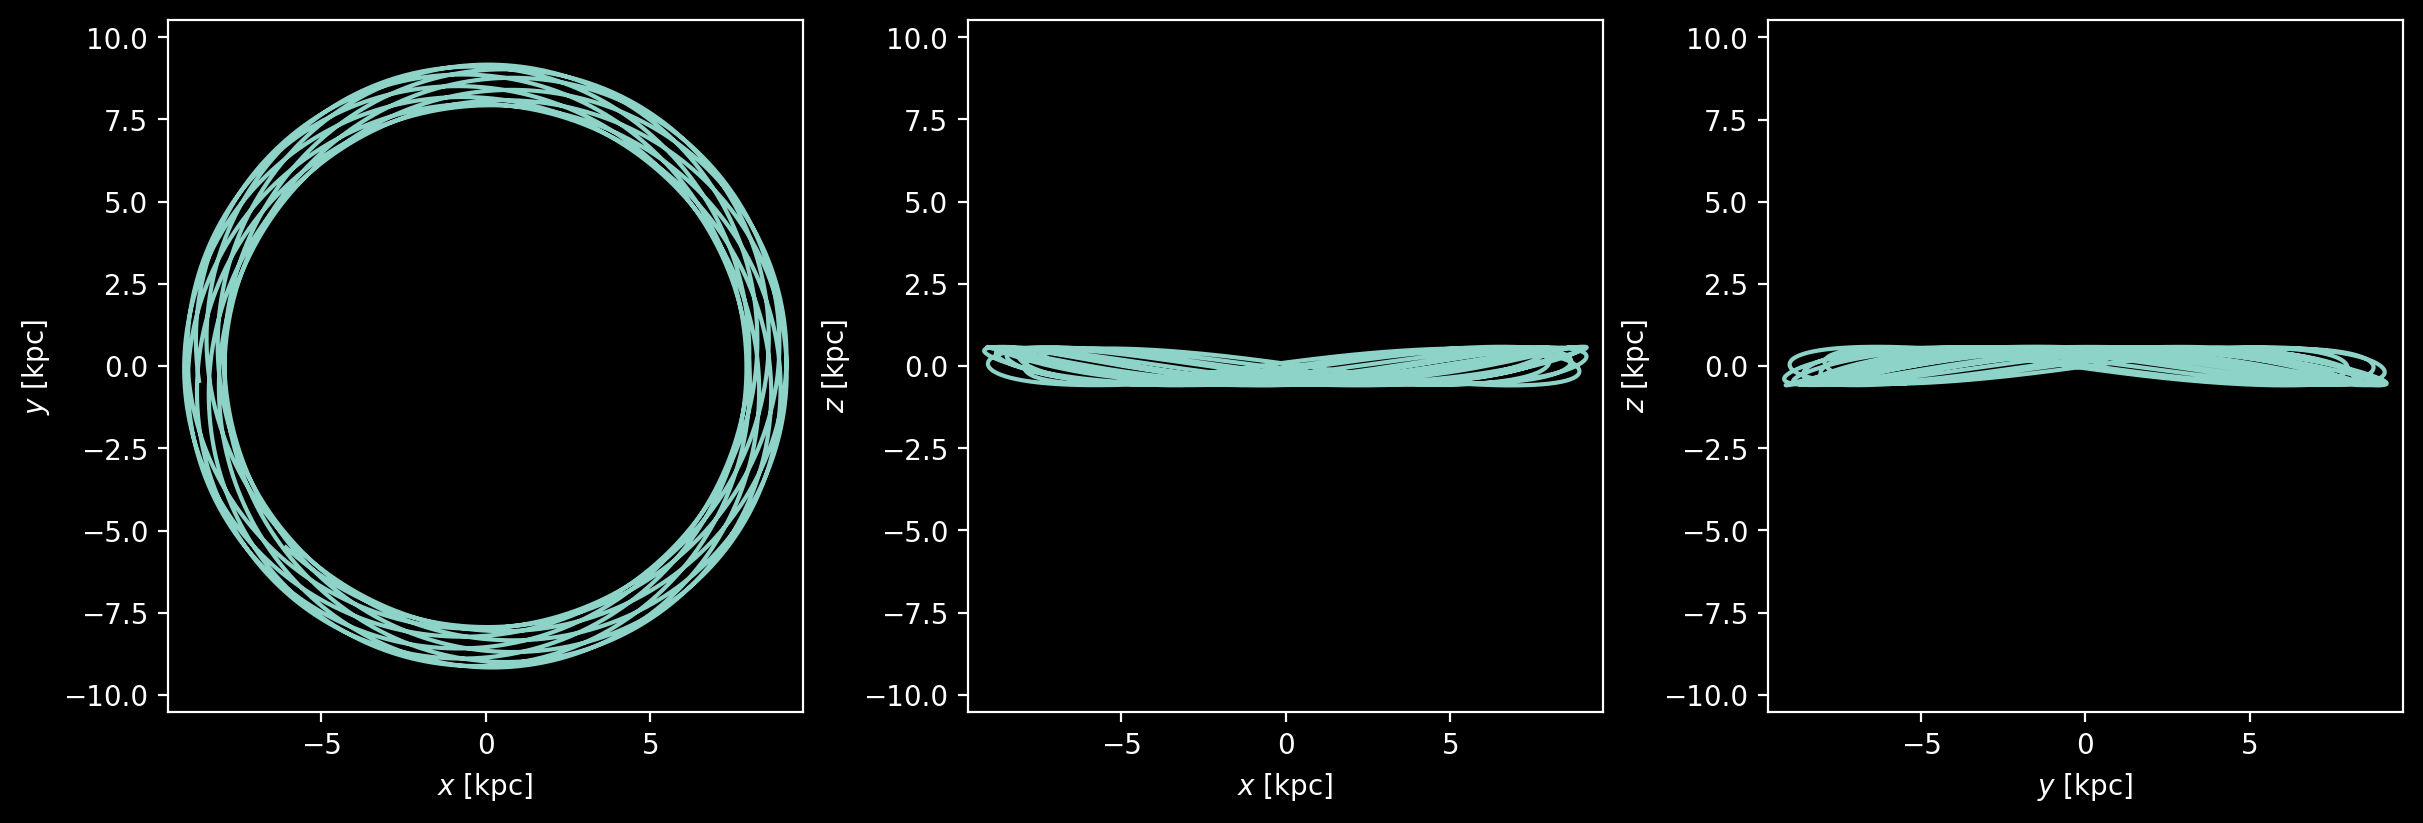

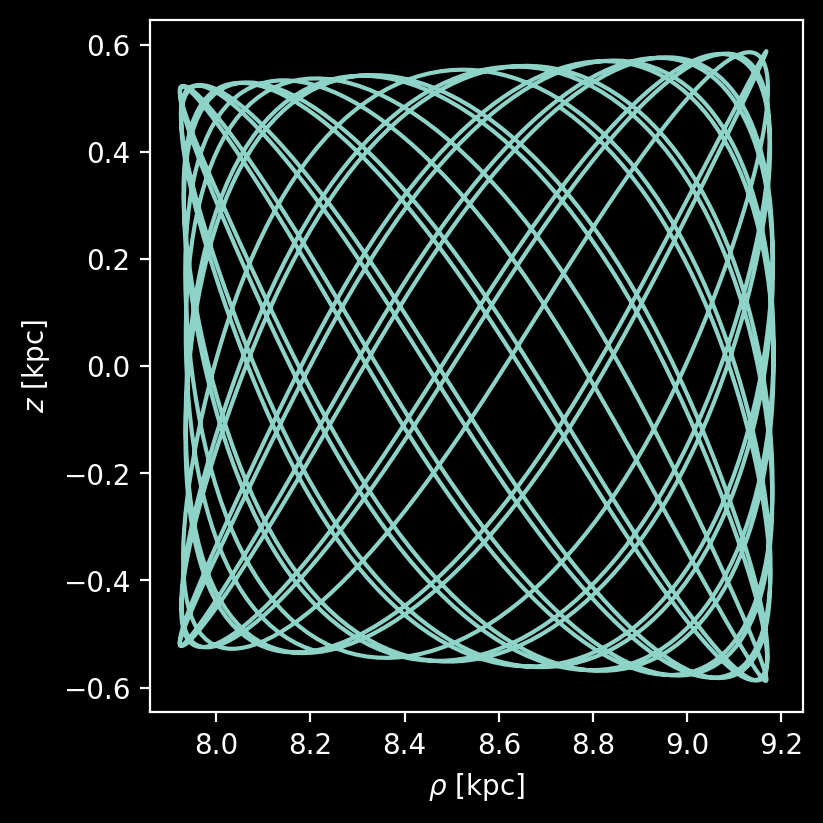

In [15]:
orbit[:, 0].plot();
orbit[:, 0].cylindrical.plot(["rho", "z"]);

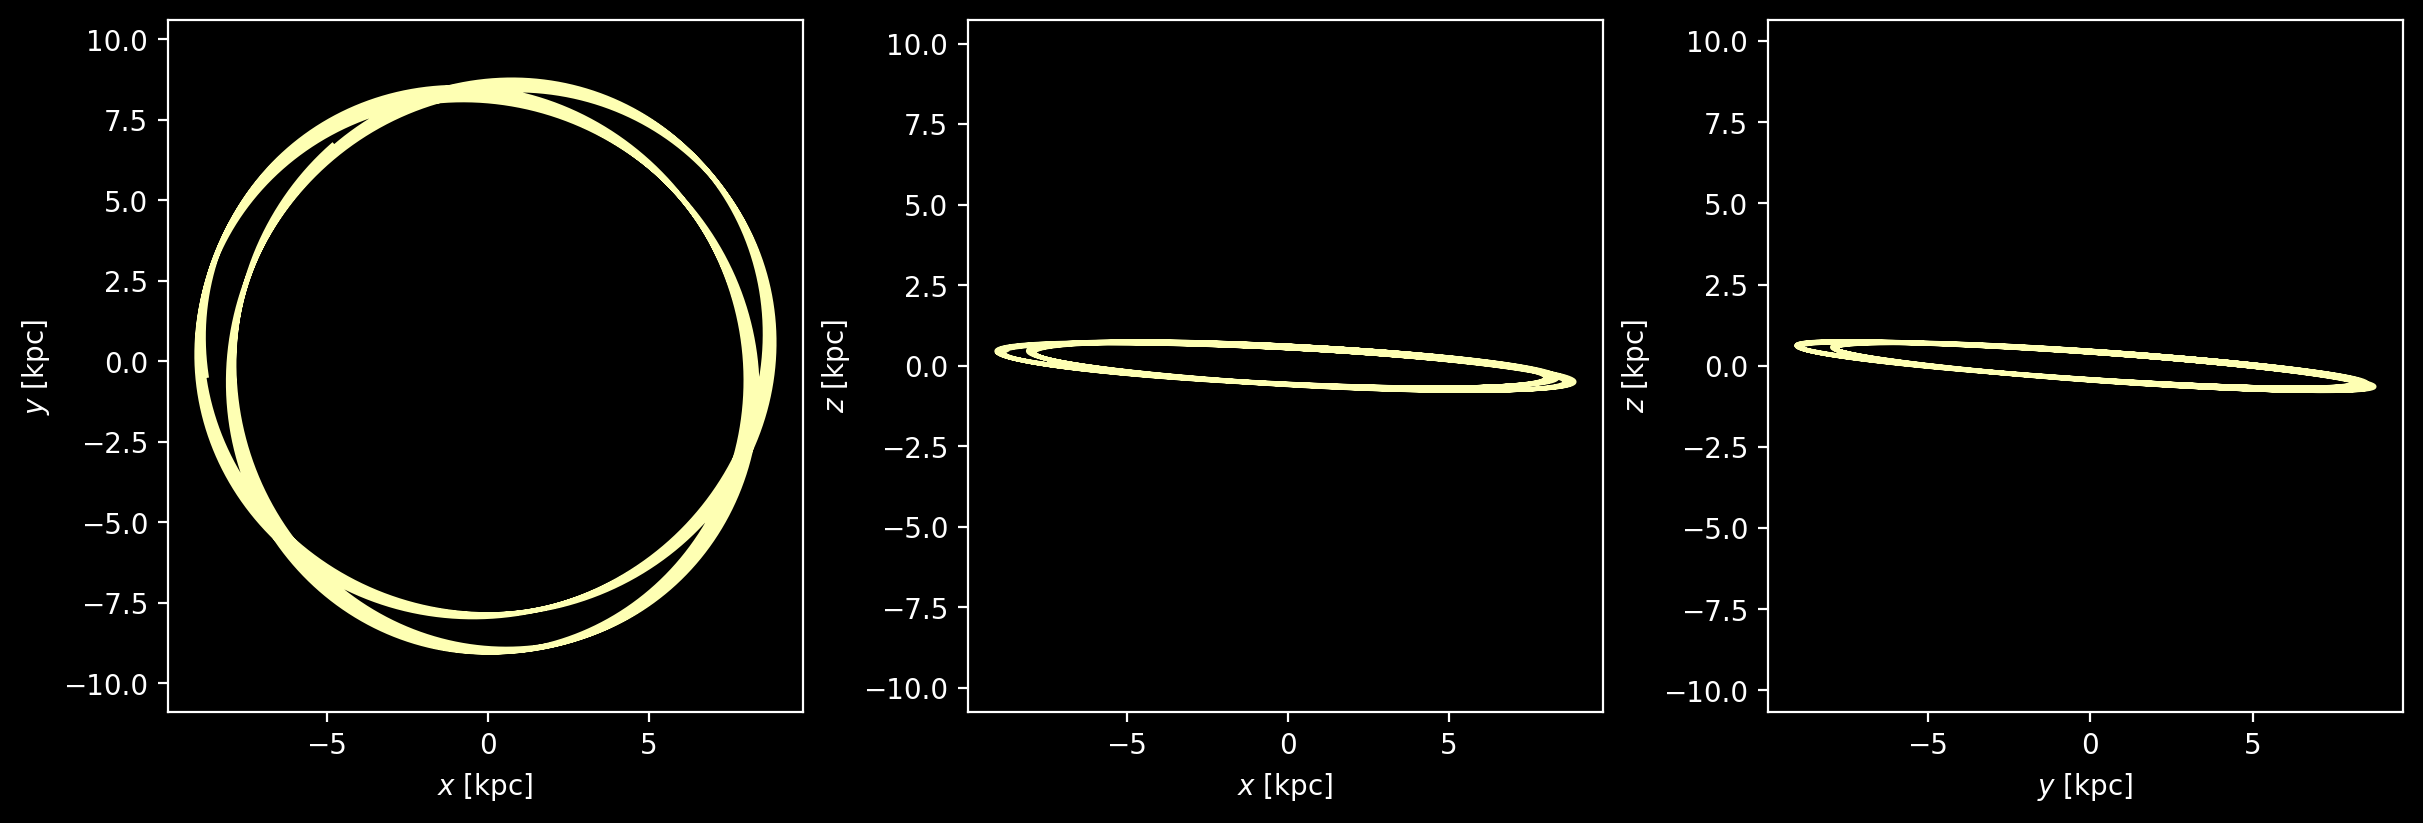

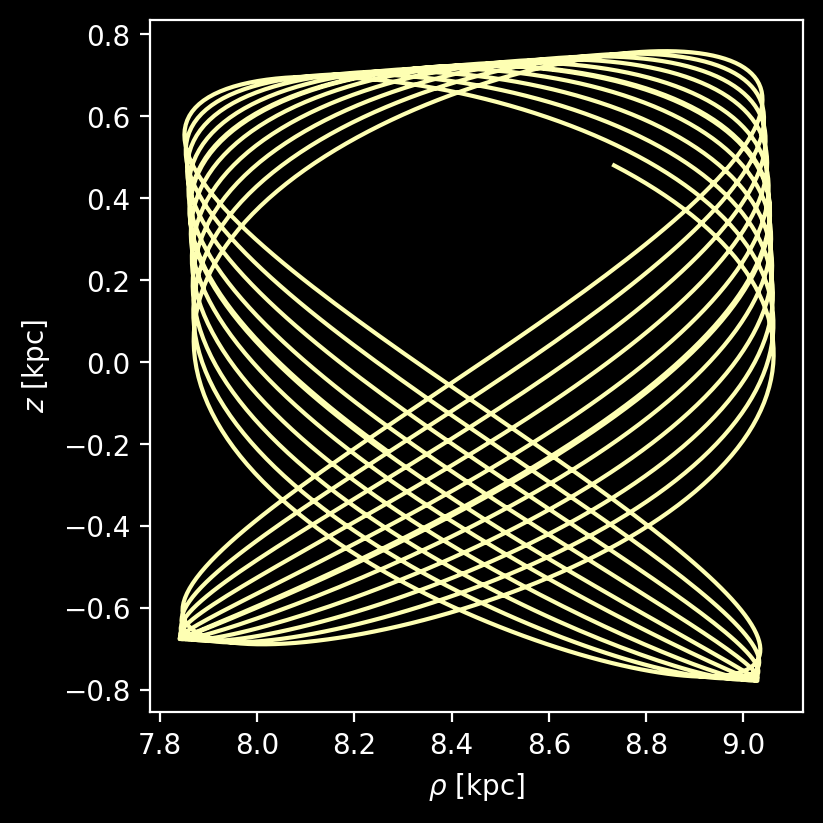

In [16]:
nfw_orbit[:, 0].plot(c="C1");
nfw_orbit[:, 0].cylindrical.plot(["rho", "z"], c="C1");

Lovely jubbly. So it seems like there is much more oscillation going on in the full MW potential rather than the NFW potential.

Let's try to quantify how the size of the cluster is changing over time. To do this I'm just going to get the standard deviation for the distribution of distances from the cluster centre.

In [17]:
def get_radius_within_cluster(w0):
    x, y, z = w0.pos.xyz
    return np.sqrt((x - x.mean())**2 + (y - y.mean())**2 + (z - z.mean())**2)

In [18]:
stds_mw = [np.std(get_radius_within_cluster(orbit[i])).to(u.kpc).value
           for i in range(orbit.shape[0])] * u.kpc
stds_nfw = [np.std(get_radius_within_cluster(nfw_orbit[i])).to(u.kpc).value
            for i in range(nfw_orbit.shape[0])] * u.kpc
stds_weird = [np.std(get_radius_within_cluster(weird_orbit[i])).to(u.kpc).value
              for i in range(weird_orbit.shape[0])] * u.kpc

In [19]:
def disc_passages(orbit):
    mean_z = orbit.z.mean(axis=1)
    sign = np.sign(mean_z)

    upwards = (np.roll(sign, 1) - sign) < 0
    downwards = (np.roll(sign, 1) - sign) > 0

    return orbit.t[upwards], orbit.t[downwards]

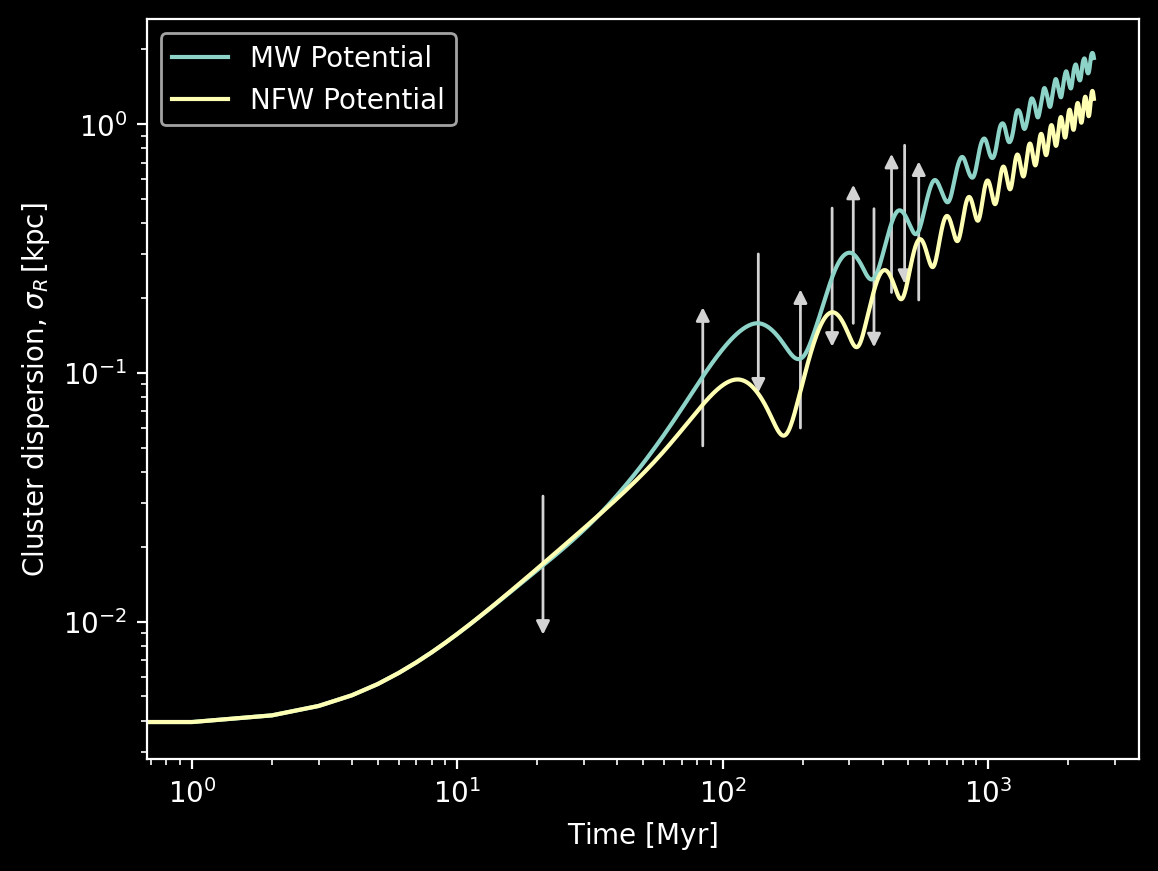

In [40]:
fig, ax = plt.subplots()

ax.plot(orbit.t, stds_mw, label="MW Potential")
ax.plot(nfw_orbit.t, stds_nfw, label="NFW Potential")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel(r"Time $[\rm Myr]$")
ax.set_ylabel(r"Cluster dispersion, $\sigma_R \, [\rm kpc]$")

ax.legend()

up, down = disc_passages(orbit)
for passage in up.to(u.Myr).value[:6]:
    if passage == 0:
        continue
    ax.annotate("", xy=(passage, stds_mw[nfw_orbit.t.value == passage].value / 2),
                xytext=(passage, stds_mw[orbit.t.value == passage].value * 2),
                arrowprops=dict(arrowstyle="<|-", color="lightgrey"), zorder=-1)

for passage in down.to(u.Myr).value[:5]:
    if passage == 0:
        continue
    ax.annotate("", xy=(passage, stds_mw[nfw_orbit.t.value == passage].value / 2),
                xytext=(passage, stds_mw[orbit.t.value == passage].value * 2),
                arrowprops=dict(arrowstyle="-|>", color="lightgrey"), zorder=-1)

plt.show()

Okay so what we're looking at here is some metric for the cluster size (standard deviation of distance from cluster centre) over time. The two different lines are for a full Milky Way potential and an equivalent mass NFW profile. The arrows indicate the first couple of disc passages for the MW potential, where down arrows mean going down through the disc and up mean the opposite.

First just looking at general trends in the MW potential line - the cluster remains pretty compact for the first couple of Myr but more rapidly expands past 10 Myr. It then starts to do some funky oscillations around 100 Myr but continues on a general trend of expansion. You can also note how the oscillations often change direction around the same time as a passage through the disc!

Now comparing the two different potentials, we can see that they follow pretty much the same trends, but offset such that the cluster will survive for longer in the NFW profile for whatever cutoff you assign as the disruption.

I was intrigued by this and wondered what happened if I played around with the NFW defaults so I made `big_flat_nfw` which is ~10 times more massive and ~2x more compact in the $z$ coordinate. So we end up with this really dense profile that the cluster hits every time it does a disc passage.

Let's take a look.

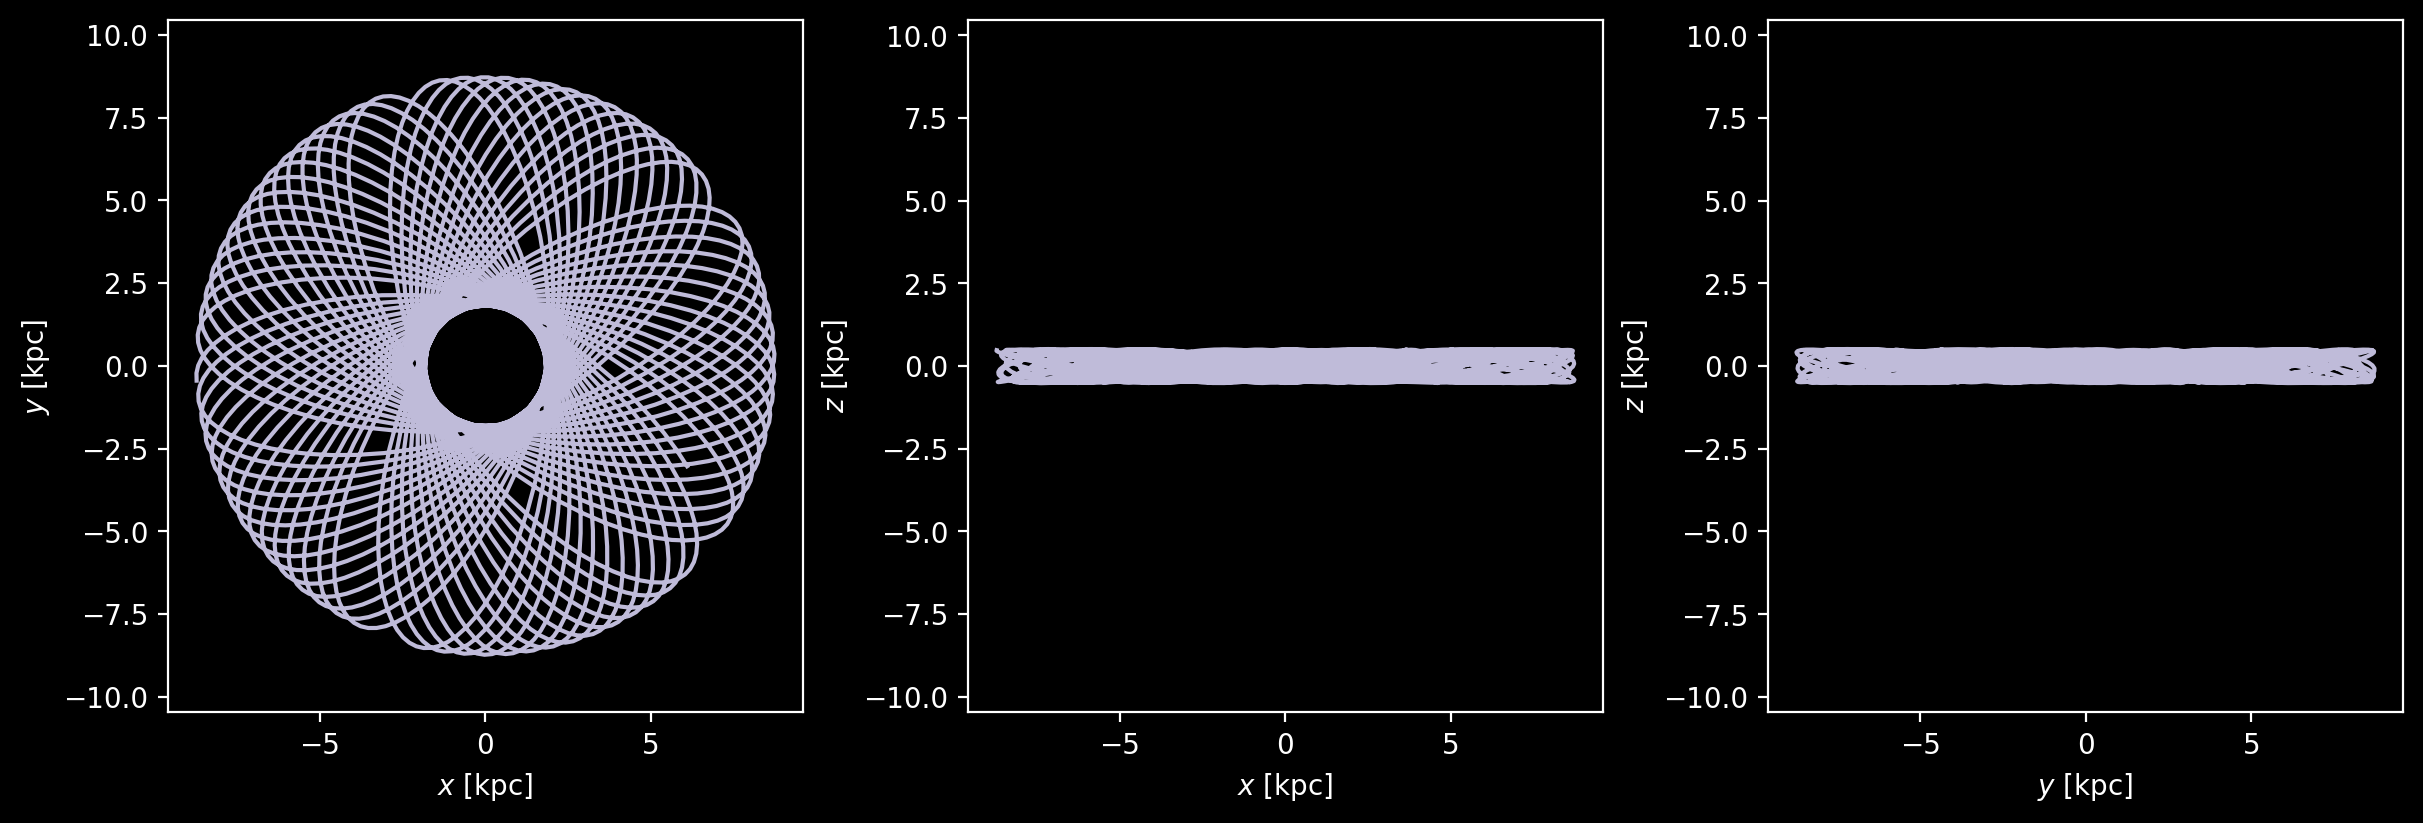

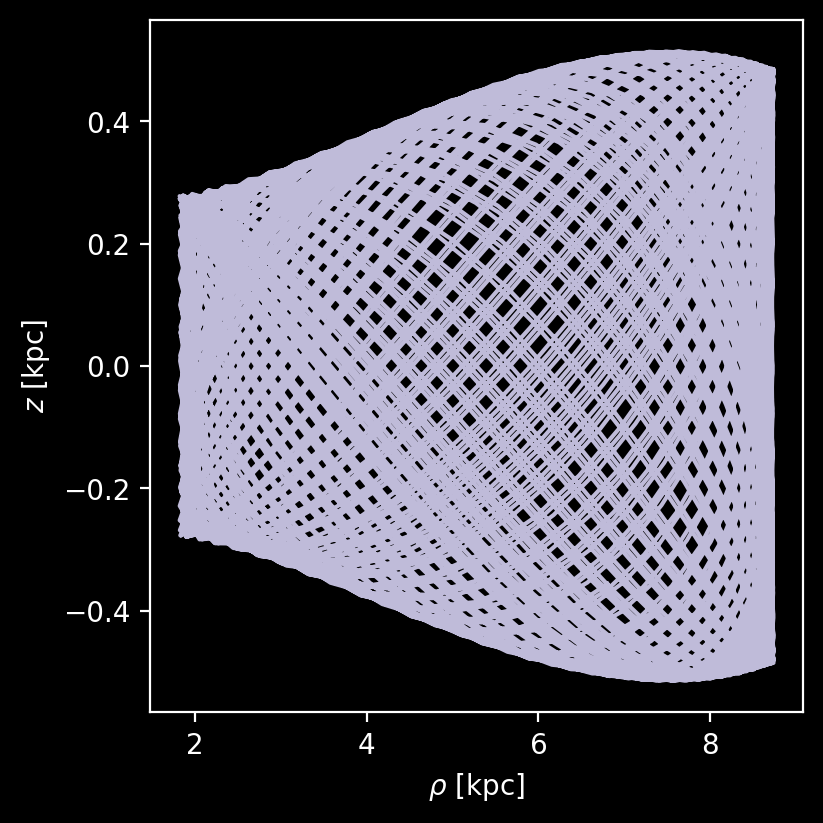

In [21]:
weird_orbit[:, 0].plot(c="C2");
weird_orbit[:, 0].cylindrical.plot(["rho", "z"], c="C2");

Did I mean to create a flower? No. Am I mad about it? Definitely not. (But we can note this potential really forces the cluster to plunge in frequently - that's going to cause some drama)

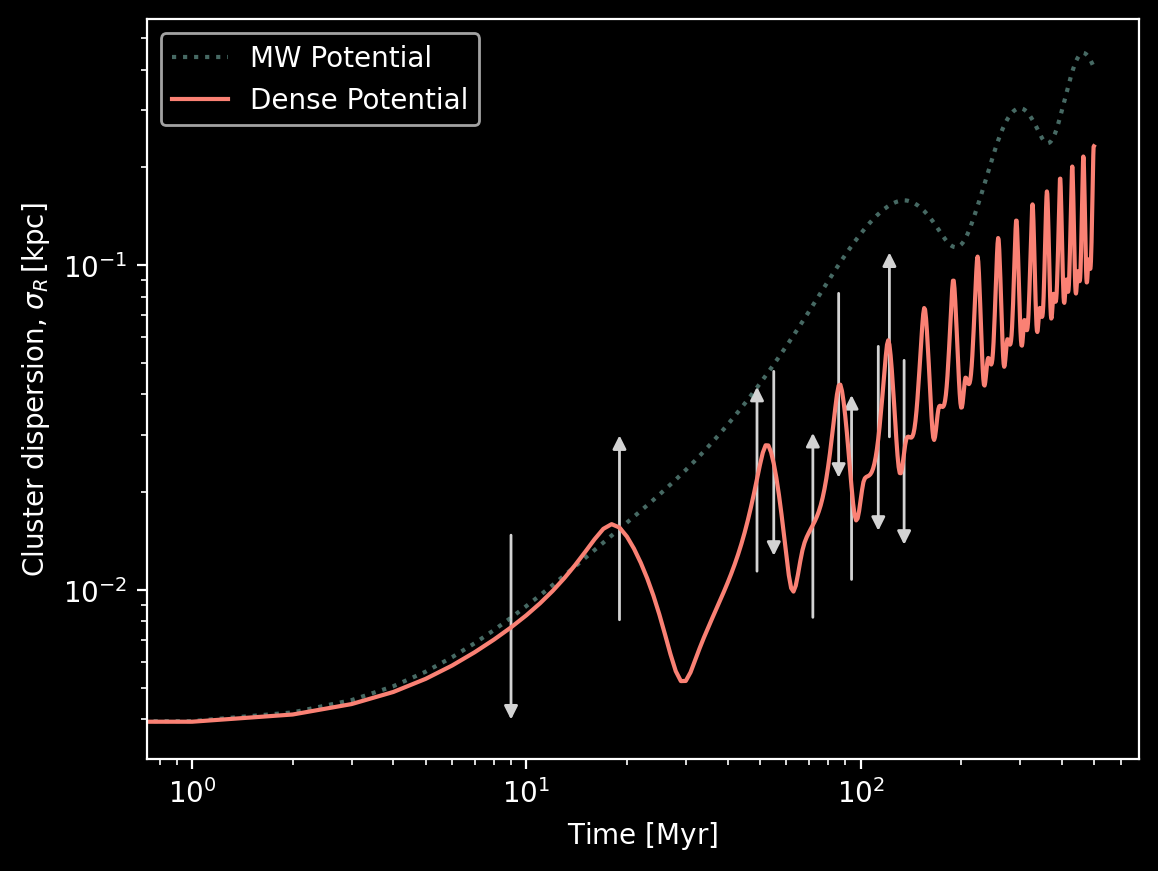

In [22]:
fig, ax = plt.subplots()

t_lim = 500
ax.plot(orbit.t[:t_lim], stds_mw[:t_lim], label="MW Potential", alpha=0.5, linestyle="dotted")
ax.plot(weird_orbit.t[:t_lim], stds_weird[:t_lim], label="Dense Potential", c="C3")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel(r"Time $[\rm Myr]$")
ax.set_ylabel(r"Cluster dispersion, $\sigma_R \, [\rm kpc]$")

ax.legend()

up, down = disc_passages(weird_orbit)
for passage in up.to(u.Myr).value[:6]:
    if passage == 0:
        continue
    ax.annotate("", xy=(passage, stds_weird[nfw_orbit.t.value == passage].value / 2),
                xytext=(passage, stds_weird[orbit.t.value == passage].value * 2),
                arrowprops=dict(arrowstyle="<|-", color="lightgrey"), zorder=-1)

for passage in down.to(u.Myr).value[:6]:
    if passage == 0:
        continue
    ax.annotate("", xy=(passage, stds_weird[nfw_orbit.t.value == passage].value / 2),
                xytext=(passage, stds_weird[orbit.t.value == passage].value * 2),
                arrowprops=dict(arrowstyle="-|>", color="lightgrey"), zorder=-1)

plt.show()

Okay so same as above but now the arrows are for this dense profile and I've faded out the MW potential. As we'd expect, there are much sharper oscillations from when this profile yanks on the cluster. We also see there are sort of kinks in the expansion - I *think* this is possibly when it gets close to the centre of the potential in $x-y$ in addition to the $z$ switch.

Either way, pretty cool. The problem with these massless particles is we don't see any sort of interaction, particularly with anything in the disc where small perturbation might strip them away from the cluster.

I tried varying my initial position and velocity dispersion and it doesn't seem to make a whole lot of difference other than to change the timescale, the shapes seem to stay pretty similar.

# Random explorations with Tom

Okay so I think at this point I've probably covered the homework stuff (hopefully?) but there are two things I was also intrigued to try and see if I could demonstrate. Both require us to use the n-body subpackage of Gala.

## Mass Movement
We mentioned in class that if you throw a cluster together then you'd see the more massive stuff sink to the centre, I wanted to see that in action. However, it turns out that running n-body integrations is **_slow_**, who knew? 🙃 So that meant I had to just use a tiny collection of particles here and so the effect isn't particularly obvious - still figured I would show you what I tried ¯\\\_(ツ)_/¯

In [23]:
def draw_masses(size, scale=1):
    """Draw masses based on a Kroupa IMF
        2.3 + 1 means use the Kroupa power law for these masses
        (1 - ...) flips it around
        (...) * scale scales up the masses to whatever you like
        (... + 0.5) offsets it to 0.5+ range
    """
    return (1 - np.random.power(2.3 + 1, size=size)) * scale + 0.5

In [35]:
# just use a small number of stars
n_nbody = 25

# grab a random subset
subset = np.random.choice(n_stars, size=n_nbody)

# pick some random masses and create potentials for each of them
# I played with the core concentration here and 20pc seems to ensure that the particles actually
# affect each other without slowing it down horribly.
masses = draw_masses(size=n_nbody, scale=75)
particle_pot = [gp.HernquistPotential(m=masses[i] * u.Msun, c=20 * u.pc, units=galactic) for i in range(n_nbody)]

# create the n-body class and integrate it forward
nbody = DirectNBody(cluster_w0[subset], particle_pot, external_potential=mw)
nbody_orbit = nbody.integrate_orbit(dt=1 * u.Myr, n_steps=1500)

Below we can see the start and end positions of each star before and after the integration. Each point is coloured by the stellar mass. I feel like you can sort of see the effect here where the more massive (closer to white) stars end up at the centre of the cluster which now streams outwards (I guess maybe I actually managed to make the stream??).

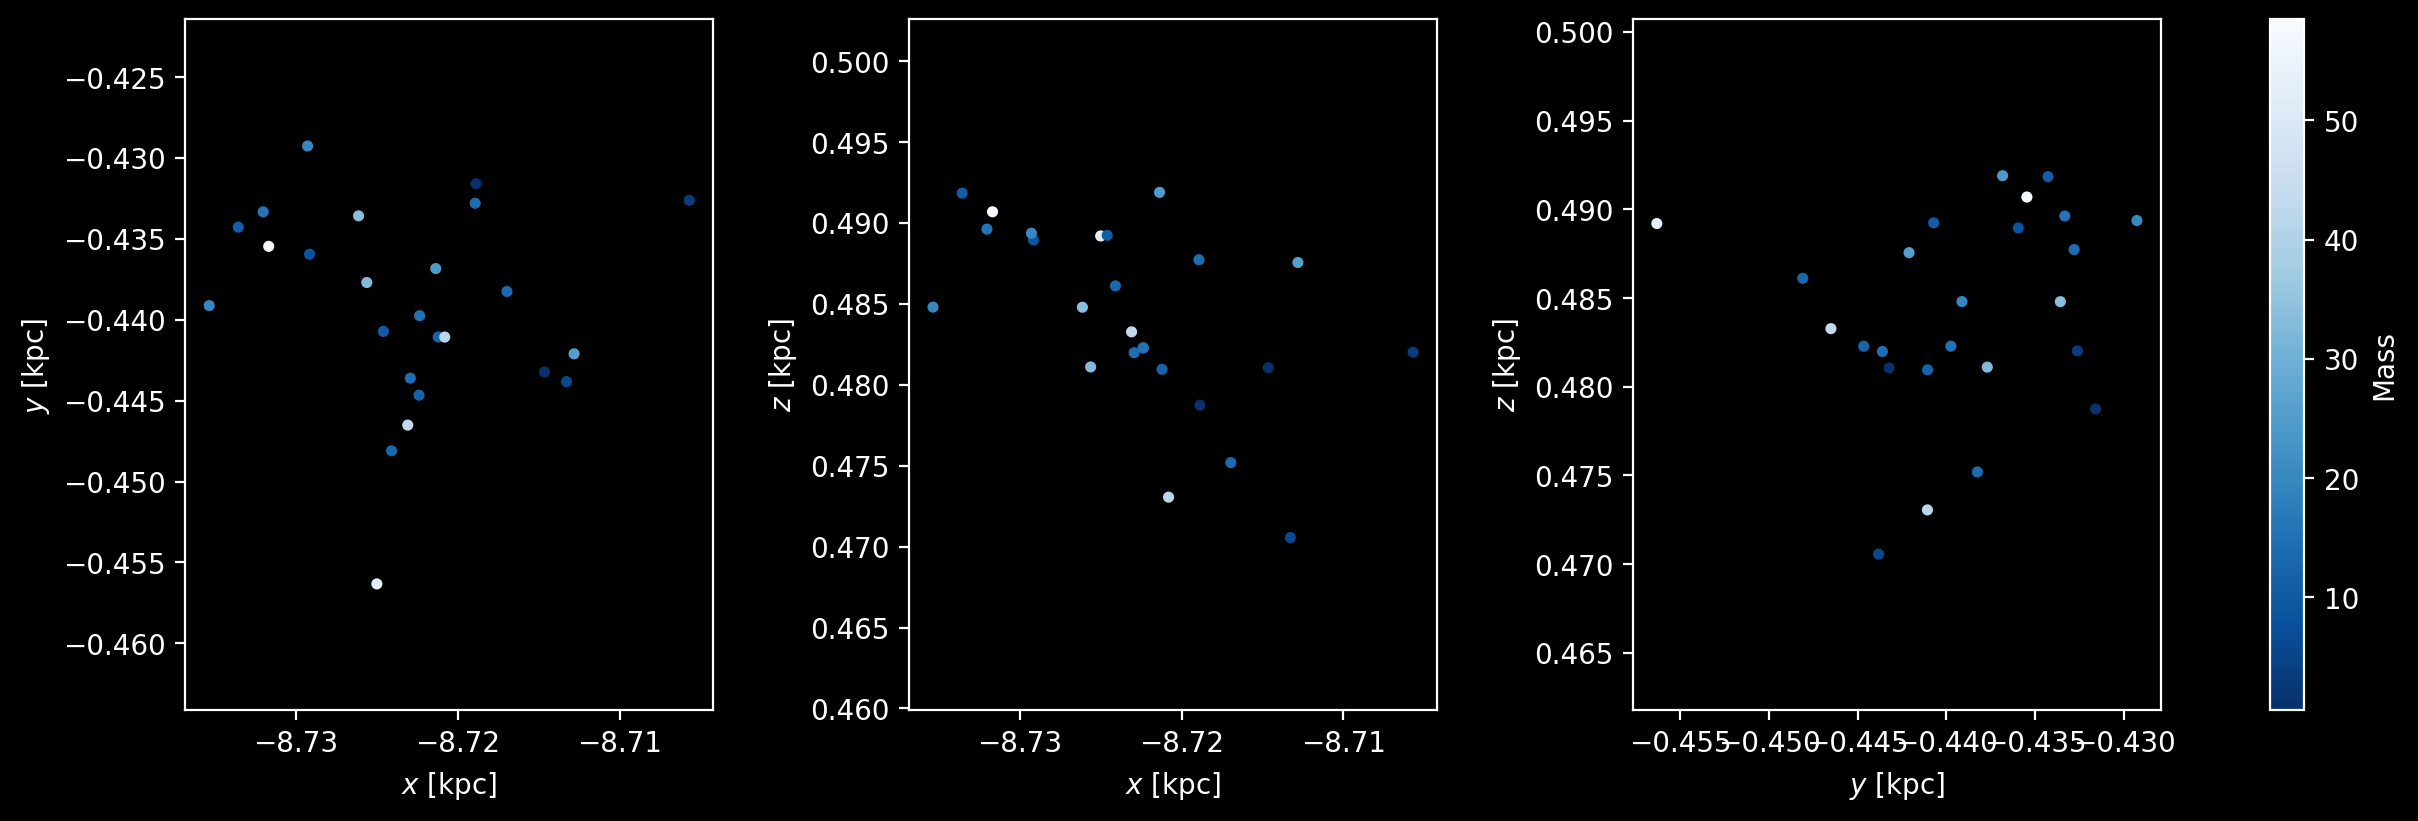

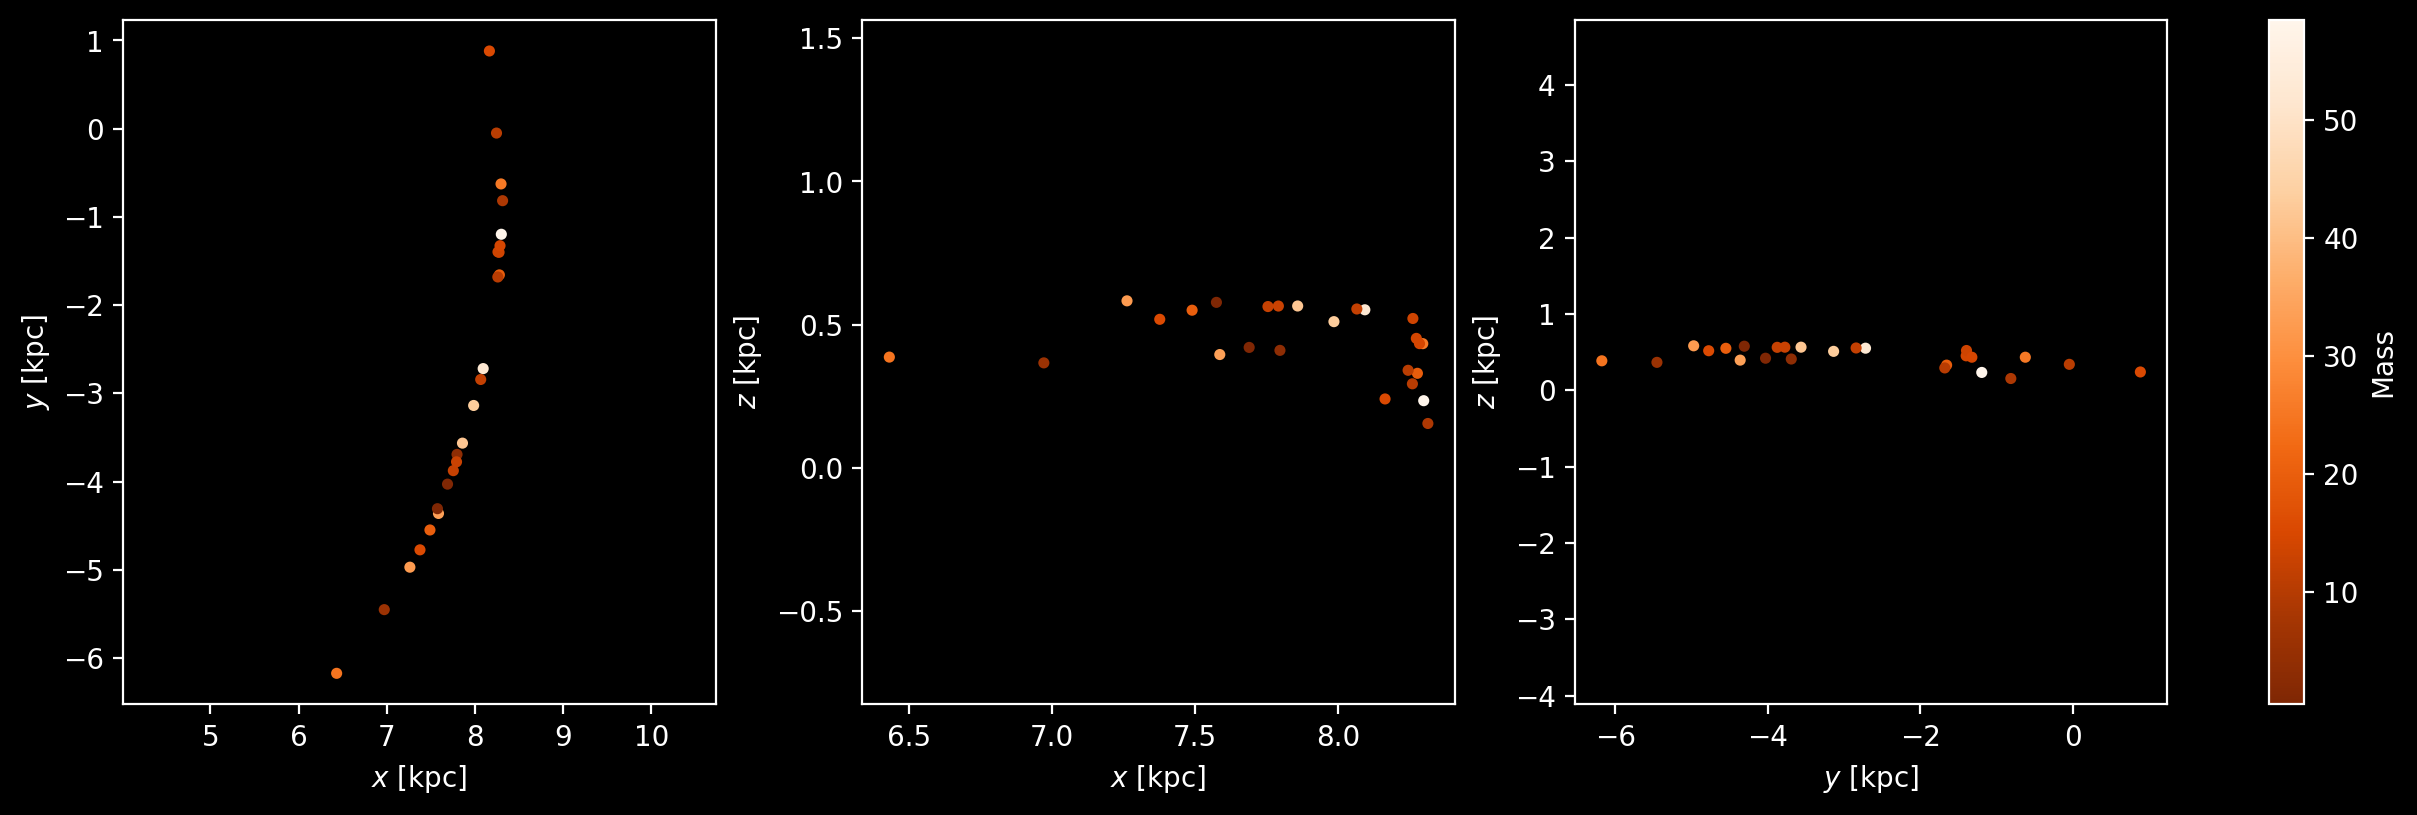

In [36]:
for i, cmap in zip([0, -1], ["Blues_r", "Oranges_r"]):
    fig = nbody_orbit[i].plot(c=masses, cmap=cmap);
    fig.colorbar(fig.gca().collections[0], ax=fig.get_axes(), label="Mass");

## Supernovae
I also thought it could be cool to run a cluster and then give one of the stars a kick after like 10 Myr and see whether that can rip it apart completely.

Damn. Well unfortunately I think I've run out of time to do this (final project season is solidly up and running 🥲). This should have been pretty doable (with some more powerful hardware at least) as I've made a function for use with `Gala` already to add kicks (see [here](https://github.com/TomWagg/cosmic-gala/blob/main/kicker/kicks.py)) but would probably have required some tuning of the individual particle potentials (and needed enough of a population) to see much of an effect rather than it just flying out of the cluster.

Hope you enjoyed my ramblings either way :p